# Effect of synthetic pretraining on real scroll data

This notebook details how pretraining on synthetically generated scrolls improves mask3d performance when finetuned on real scroll volumes. 

We finetuned on real scroll data for 400 epochs (the training run names inaccurately state 200 epochs, but they were extended). The dataset of real scroll volumes consisted of 66/14 (training/validation) items. Volumes in the dataset had shape (256, 256, 256) but were downsampled for training, as seen in training code.

Synthetic pretraining was run for 0, 200, 600, 800, 1200, and 1400 epochs. We lost the runs for 400 epochs and the 1000-epoch run stopped halfway through. Both are skipped in this analysis.
Pretraining was run from this repo in the state of commit `3bd437068afaace93566c04521dc5d808f91df62` (and commit `6891c9dd2ef9347130c311c35e5a8c9bbead871b` of `synthetic-pages`) for the stated number of epochs. You can reproduce with

```sh
python main_instance_segmentation.py general.experiment_name="synthetic_pretraining_reproduction" trainer.max_epochs=$NUM_EPOCHS general.initial_weights_path=weights_path
```

Pretrained weights are available for replication on request. Otherwise, the pretraining step must be run for the desired number of epochs and then finetuned.

![title](img/pretraining_advantage.png)

The final loss for each run was collected and the finetuned training loss can be seen in the following plot (reproduction code included in the subsequent block):

In [48]:
import re
from pathlib import Path
from typing import Iterable, List, Union

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


def _extract_pretraining_epochs(column_name: str) -> int:
    if "from-new-weights" in column_name:
        return 0
    if (match := re.search(r"from-synthetic-(\d+)-epochs", column_name)):
        return int(match.group(1))
    numbers = re.findall(r"(\d+)-epochs", column_name)
    return int(numbers[-1]) if numbers else 0


def plot_final_loss(
    csv_path: Union[str, Path],
    column_regex: str,
    title: str,
    *,
    tail: int = 10,
    exclude_epochs: Union[int, Iterable[int], None] = None,
) -> None:
    """Plot mean of last `tail` rows for each `<column_regex>` metric."""
    df = pd.read_csv(csv_path)
    metric_cols: List[str] = [c for c in df.columns if re.search(column_regex, c)]
    if not metric_cols:
        raise ValueError(f"No columns matching /{column_regex}/ in {csv_path!s}")

    # Mean over the last `tail` steps
    means = df.tail(tail)[metric_cols].mean()

    # Build tidy table
    results = (
        means.dropna()  # ➊ drop columns whose mean is NaN
        .reset_index()
        .rename(columns={"index": "column_name", 0: "average_final_loss"})
    )
    results["pretraining_epochs"] = results["column_name"].apply(
        _extract_pretraining_epochs
    )

    # Optional exclusion
    if exclude_epochs is not None:
        if isinstance(exclude_epochs, int):
            exclude_set = {exclude_epochs}
        else:
            exclude_set = set(exclude_epochs)
        results = results[~results["pretraining_epochs"].isin(exclude_set)]

    results = results.sort_values("pretraining_epochs").reset_index(drop=True)

    display(results)  # manual verification

    # Plot
    plt.figure()
    plt.plot(
        results["pretraining_epochs"],
        results["average_final_loss"],
        marker="o",
    )
    plt.xlabel("Number of pre-training epochs")
    plt.ylabel(f"Average {column_regex.strip('$')} (last {tail} steps)")
    plt.title(title)
    plt.grid(True)
    plt.show()




,column_name,average_final_loss,pretraining_epochs
0,finetune-200-epochs-from-new-weights - train_l...,69.316726,0
1,finetune-200-epochs-from-synthetic-199-epochs ...,55.185666,199
2,finetune-200-epochs-from-synthetic-599-epochs ...,49.965970,599
3,finetune-200-epochs-from-synthetic-799-epochs ...,47.918254,799
4,finetune-200-epochs-from-synthetic-1199-epochs...,45.128074,1199
5,finetune-200-epochs-from-synthetic-1399-epochs...,43.593883,1399


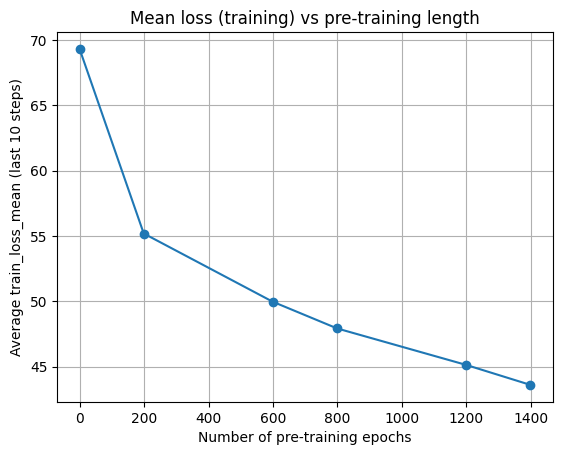

In [51]:
plot_final_loss(
    "img/pretraining_advantage.csv",
    r"train_loss_mean$",
    title="Mean loss (training) vs pre-training length",
)

The 400 epoch run and 1000 epoch run were omitted for reasons described above.

## Validation metrics

This section includes validation metrics for the mean mask loss and mean dice loss.

![mean_loss_mask](img/mean_loss_mask.png)

,column_name,average_final_loss,pretraining_epochs
0,finetune-200-epochs-from-new-weights - val_mea...,0.911655,0
1,finetune-200-epochs-from-synthetic-199-epochs ...,0.720609,199
2,finetune-200-epochs-from-synthetic-599-epochs ...,0.550409,599
3,finetune-200-epochs-from-synthetic-799-epochs ...,0.493348,799
4,finetune-200-epochs-from-synthetic-1199-epochs...,0.472954,1199
5,finetune-200-epochs-from-synthetic-1399-epochs...,0.473370,1399


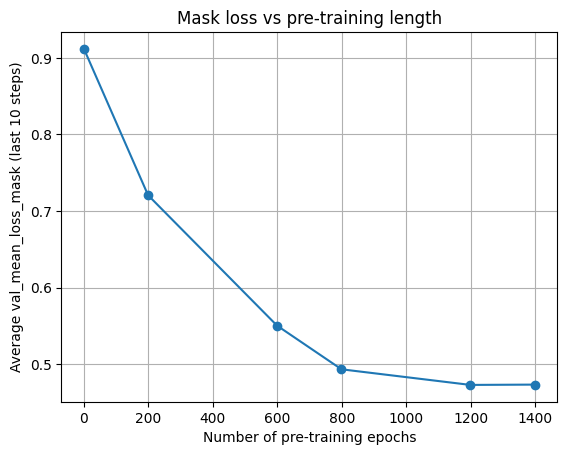

In [52]:
plot_final_loss(
    "img/mean_loss_mask.csv",
    r"val_mean_loss_mask$",
    title="Mask loss vs pre-training length",
    exclude_epochs={999},
)


![mean_loss_dice](img/mean_loss_dice.png)

,column_name,average_final_loss,pretraining_epochs
0,finetune-200-epochs-from-new-weights - val_mea...,1.140892,0
1,finetune-200-epochs-from-synthetic-199-epochs ...,0.872052,199
2,finetune-200-epochs-from-synthetic-599-epochs ...,0.641940,599
3,finetune-200-epochs-from-synthetic-799-epochs ...,0.576291,799
4,finetune-200-epochs-from-synthetic-1199-epochs...,0.544545,1199
5,finetune-200-epochs-from-synthetic-1399-epochs...,0.541590,1399


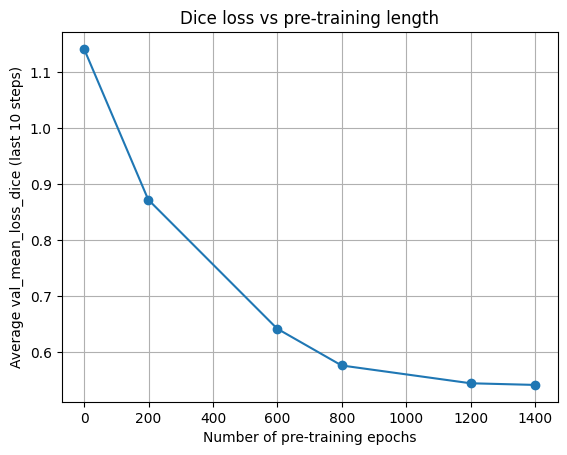

In [53]:

plot_final_loss(
    "img/mean_loss_dice.csv",
    r"val_mean_loss_dice$",
    title="Dice loss vs pre-training length",
    exclude_epochs={999},
)